This notebook demonstrates the process of predicting and analyzing topological defects in physical systems by utilizing both traditional winding number methods and cCNN. It covers the steps involved in loading data from files, processing vector fields, extracting candidate defect locations, making predictions, and visualizing the results across a sequence of frames. The notebook is intended for exploring how different prediction techniques perform on a series of experimental or simulated data inputs, providing insights into model accuracy and spatial-temporal patterns of defects.


In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))
import utils.project_functions as pf
import torch


In [2]:
def timepline_plot(n_frames, file_name, method, model, device, plot=True, *args, **kwargs):
    frames = range(1,n_frames+1)

    predictions_df = pd.DataFrame(columns=["x","y","prediction","confidence","tag","frame"])
    tag = file_name.split("/")[-2].split("_")[1]


    for frame in frames:
        try:
            eigen_vals, eigen_vecs = pf.load_and_pad_vtk(file_name.format(frame), pad_width=4)
        except:
            print(f"File not found: {file_name.format(frame)}")
            continue

        winding_numbers, flips = pf.calculate_winding_number(eigen_vecs, pad_width=4)
        winding_numbers *= -1
        centroids = pf.find_candidates_by_winding_number(winding_numbers)
        defects = np.round([(c[1], c[0]) for c in centroids]).astype(int)

        if method == "winding_number":
            labels = [ 1 if winding_numbers[i,j] > 0 else 0 for i,j in defects] 
            predictions = pd.DataFrame(list(zip(defects[:,0], defects[:,1], labels)), columns=["x","y","prediction"])
            predictions["confidence"] = 1
            predictions["tag"] = tag
            predictions["frame"] = frame
            predictions_df = pd.concat([predictions_df, predictions])

        elif method == "cnn":
            predictions = pf.predict_field(model, eigen_vals, eigen_vecs, defects, device=device, filename=f"w")
            _x, _y = [sample.position[0] for sample in predictions], [sample.position[1] for sample in predictions]
            _labels = [sample.pseudo_label for sample in predictions]
            _confidence = [sample.pseudo_label_confidence for sample in predictions]
            _tag = [f"{tag}" for _ in range(len(_x))]
            _frame = [frame for _ in range(len(_x))]
            predictions_df = pd.concat([predictions_df, pd.DataFrame(list(zip(_x,_y, _labels, _confidence, _tag, _frame )),columns=["x","y","prediction","confidence","tag","frame"])])


    predictions_df["frame"] = predictions_df["frame"].astype(int)

    if plot:
        pf.plot_experiments_evolution(predictions_df, y_scale=kwargs.get("y_scale",10))
    
    return predictions_df


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = pf.load_model(file_path="../Models/cnn_2025-08-12.pth")

/home/ipalos/Documents/Maestria/Tesis V2/utils/project_functions.py:538: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


/tmp/ipykernel_5168/2809617100.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions_df = pd.concat([predictions_df, pd.DataFrame(list(zip(_x,_y, _labels, _confidence, _tag, _frame )),columns=["x","y","prediction","confidence","tag","frame"])])


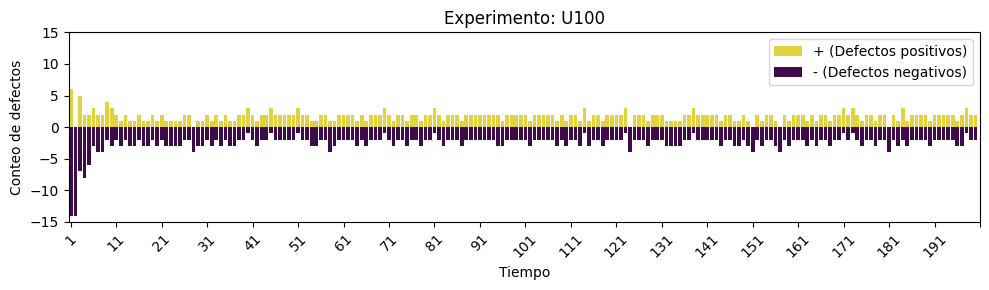

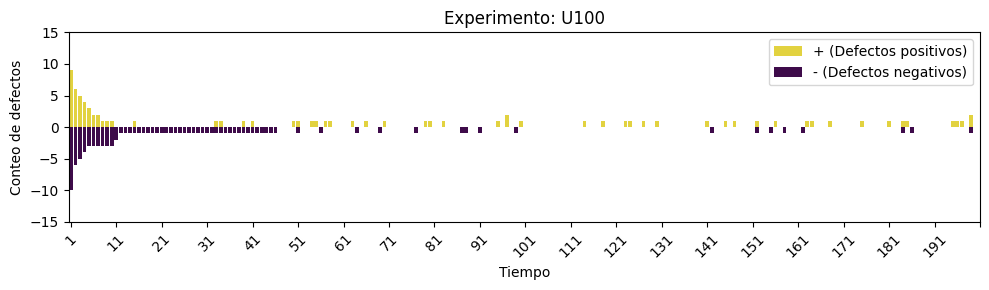

In [4]:
n_frames = 200
file_name = "../Data/MAI_U100_L_096_A/mpcd_{}.vtk"
u100_df_winding = timepline_plot(n_frames, file_name, "winding_number", model, device, y_scale=15)
u100_df_cnn = timepline_plot(n_frames, file_name, "cnn", model, device, y_scale=15)


/tmp/ipykernel_5168/2809617100.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions_df = pd.concat([predictions_df, pd.DataFrame(list(zip(_x,_y, _labels, _confidence, _tag, _frame )),columns=["x","y","prediction","confidence","tag","frame"])])


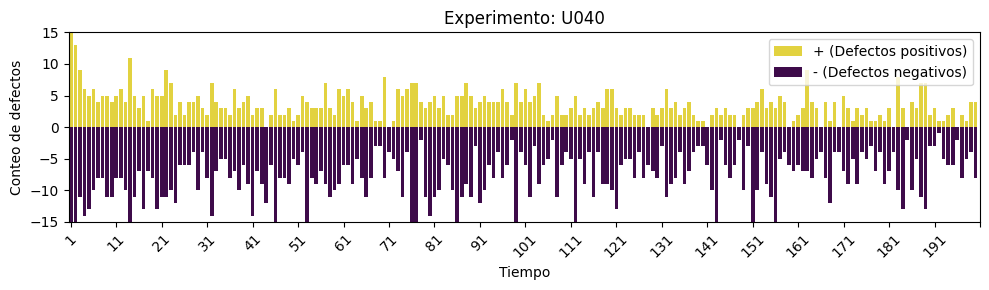

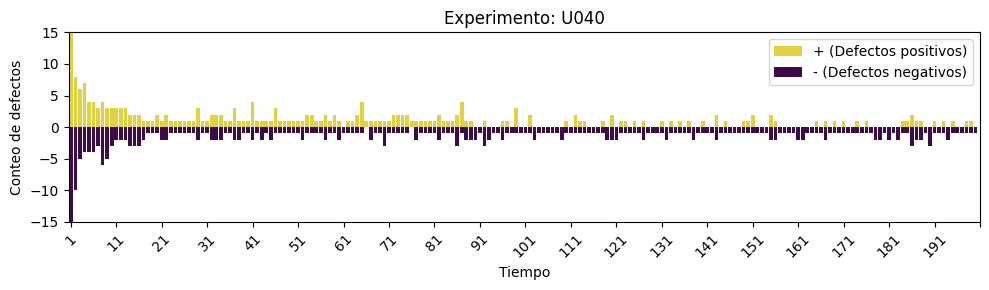

In [5]:
n_frames = 200
file_name = "../Data/MAI_U040_L_128_A/mpcd_{}.vtk"
u040_df_winding = timepline_plot(n_frames, file_name, "winding_number", model, device, y_scale=15)
u040_df_cnn = timepline_plot(n_frames, file_name, "cnn", model, device, y_scale=15)


In [6]:
u040_df_winding.to_csv("../Predictions/u040_df_winding_251008.csv")
u040_df_cnn.to_csv("../Predictions/u040_df_cnn_251008.csv")
u100_df_winding.to_csv("../Predictions/u100_df_winding_251008.csv")
u100_df_cnn.to_csv("../Predictions/u100_df_cnn_251008.csv")


In [7]:
def process_defects_count(df):
    # Group by frame and prediction to count defects
    defects_count = df.groupby(['frame', 'prediction']).size().unstack(fill_value=0)
    
    # Ensure we have columns for both 0 and 1 predictions
    if 0 not in defects_count.columns:
        defects_count[0] = 0
    if 1 not in defects_count.columns:
        defects_count[1] = 0
        
    # Keep only the columns we need and rename them
    defects_count = defects_count[[0, 1]]
    defects_count.columns = ['negative', 'positive']
    
    # Make negative defects count negative for plotting
    defects_count['negative'] = -defects_count['negative']
    
    return defects_count

In [8]:
# Process both datasets
winding_counts_040 = process_defects_count(u040_df_winding)
print("\nWinding counts head:")
print(winding_counts_040.head())

cnn_counts_040 = process_defects_count(u040_df_cnn)
print("\nCNN counts head:")
print(cnn_counts_040.head())

winding_counts_100 = process_defects_count(u100_df_winding)
print("\nWinding counts head:")
print(winding_counts_100.head())

cnn_counts_100 = process_defects_count(u100_df_cnn)
print("\nCNN counts head:")
print(cnn_counts_100.head())

# Save the processed data for TikZ plotting
winding_counts_040.to_csv('../Predictions/u040_defects_count_winding_251008.dat', sep=' ', index=True)
cnn_counts_040.to_csv('../Predictions/u040_defects_count_cnn_251008.dat', sep=' ', index=True)
winding_counts_100.to_csv('../Predictions/u100_defects_count_winding_251008.dat', sep=' ', index=True)
cnn_counts_100.to_csv('../Predictions/u100_defects_count_cnn_251008.dat', sep=' ', index=True)



Winding counts head:
       negative  positive
frame                    
1           -48        21
2           -18        13
3           -11         9
4           -14         6
5           -13         5

CNN counts head:
       negative  positive
frame                    
1           -20        23
2           -10         8
3            -5         6
4            -4         7
5            -4         4

Winding counts head:
       negative  positive
frame                    
1           -14         6
2           -14         0
3            -7         5
4            -8         2
5            -6         2

CNN counts head:
       negative  positive
frame                    
1           -10         9
2            -6         6
3            -5         5
4            -4         4
5            -3         3


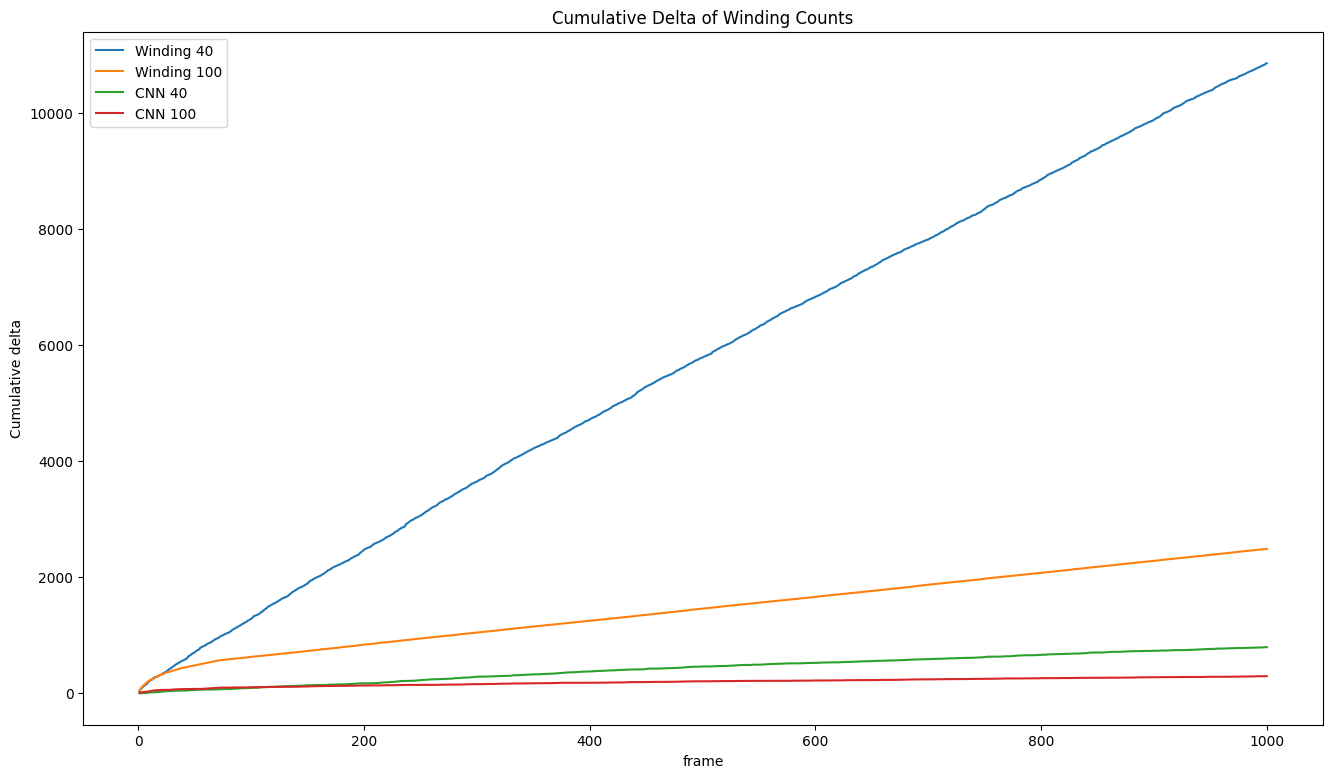

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt



winding_counts_040["delta"] = winding_counts_040["positive"] - winding_counts_040["negative"]
winding_counts_040["delta_cumsum"] = winding_counts_040["delta"].cumsum()
cnn_counts_040["delta"] = cnn_counts_040["positive"] - cnn_counts_040["negative"]
cnn_counts_040["delta_cumsum"] = cnn_counts_040["delta"].cumsum()


winding_counts["delta"] = winding_counts["positive"] - winding_counts["negative"]
winding_counts["delta_cumsum"] = winding_counts["delta"].cumsum()
cnn_counts["delta"] = cnn_counts["positive"] - cnn_counts["negative"]
cnn_counts["delta_cumsum"] = cnn_counts["delta"].cumsum()

winding_counts_040.to_csv('../Predictions/u040_defects_count_winding_cumsum.dat', sep=' ', index=True)
cnn_counts_040.to_csv('../Predictions/u040_defects_count_cnn_cumsum.dat', sep=' ', index=True)
winding_counts.to_csv('../Predictions/u100_defects_count_winding_cumsum.dat', sep=' ', index=True)
cnn_counts.to_csv('../Predictions/u100_defects_count_cnn_cumsum.dat', sep=' ', index=True)



sns.lineplot(x=winding_counts_040.index, y=winding_counts_040["delta_cumsum"], label="Winding 40")
sns.lineplot(x=winding_counts.index, y=winding_counts["delta_cumsum"], label="Winding 100")
sns.lineplot(x=cnn_counts_040.index, y=cnn_counts_040["delta_cumsum"], label="CNN 40")
sns.lineplot(x=cnn_counts.index, y=cnn_counts["delta_cumsum"], label="CNN 100")
plt.xlabel("frame")
plt.ylabel("Cumulative delta")
plt.title("Cumulative Delta of Winding Counts")
plt.legend()
plt.show()
